In [1]:
import numpy as np
import matplotlib.pyplot as plt
import natsort, glob, h5py
from scipy.optimize import curve_fit
import scipy.signal

In [2]:
#path = r"C:/Data/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/"
path = '/gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/'
SRS_gain = 100 # gain on the SRS bandpass filter
peak_threshold = 700 # upper bound of pedestal
breakdown = 27.4 # breakdown voltage of the SiPM
pedestal = 275 # center of noise pedestal peak

file_list = natsort.realsorted(glob.glob(path + "mca_*.h5"))[::-1]
print("Found %d files"%len(file_list))

Found 10 files


In [3]:
def gauss_fun(x, A, mu, sig):
    return A * np.exp( -(x-mu)**2/(2*sig**2) )

def lin_fun(x, m, x1):
    return m*(x-x1)

def lin_fun_const(x, m):
    return lin_fun(x,m,0)

In [4]:
def rebin_histogram(bins, counts, new_bin_size):
    """Rebin a histogram to a new bin size.
    Parameters:
        bins (np.ndarray): The bin edges of the histogram.
        counts (np.ndarray): The number of counts in each bin.
        new_bin_size (float): The size of the new bins.
    Returns:
        np.ndarray: The new bin edges.
        np.ndarray: The new bin counts.
    """
    # Find the new number of bins
    new_nbins = int((bins[-1] - bins[0]) / new_bin_size)
    # Create the new bin edges
    new_bins = np.linspace(bins[0], bins[-1], new_nbins + 1)
    # Digitize the original bins into the new bins
    digitized_bins = np.digitize(bins, new_bins)
    # Calculate the new counts
    new_counts = np.array([counts[digitized_bins == i].sum() for i in range(1, new_nbins + 1)])

    new_centers = new_bins[:-1] + np.diff(new_bins)/2
    return new_centers, new_counts

In [5]:
def find_peaks_and_fit(x_data, y_data, voltage, min_distance=20, max_peaks=5, min_thresh=10):
    # Find the peaks in the spectrum using the find_peaks function from scipy.signal
    
    peaks_index, _ = scipy.signal.find_peaks(y_data, distance=min_distance)
    
    # Fit each peak with a Gaussian function using the curve_fit function from scipy
    gain_info = [] # parameters to fit the gain
    peak_params = [] # parameters to plot the gaussian
    peak_number = 1 # corresponds to single photoelectron peak
    peaks = [] # list of where all the peaks are that are used in the fits
    for peak in peaks_index:
        if peak_number > max_peaks: # stopping the loop after we have reached the max number of peaks
            break

        if peak < min_thresh:
            continue
        
        peaks.append(np.array([x_data[peak], y_data[peak]]))
        
        # Initial guess for the Gaussian parameters
        amplitude_guess = y_data[peak]
        mean_guess = x_data[peak]
        standard_deviation_guess = 50
        initial_guess = [amplitude_guess, mean_guess, standard_deviation_guess]
        
        # finding the section of the data around the given peak
        if voltage < 30:
            peak_range = 150 # picking a smaller range of values to fit over for the lower OV files
        else:
            peak_range = 500
        
        if peak_number == 1: # trying to not include the pedestal for the first peak
            cut = (x_data < (x_data[peak] + peak_range)) & (x_data > (x_data[peak] - 200))
        else:
            cut = (x_data < (x_data[peak] + peak_range)) & (x_data > (x_data[peak] - peak_range))
        peak_x = x_data[cut] # x values of peak for fitting
        peak_y = y_data[cut] # y values of peak for fitting
        
        # Perform the curve fitting
        try:
            # trying to fit the peaks
            params, params_covariance = curve_fit(gauss_fun, peak_x, peak_y, p0=initial_guess)
            # params are returned as amplitude, mean, std dev
            print('Guess: ', initial_guess)
            print('Params: ', params)
            peak_params.append(params)
        except RuntimeError as r:
            # if curve fit doesn't work then we will just use the peak amplitude and center that find_peaks found
            print('fit failed')
            peak_params.append(initial_guess)
            gain_info.append([peak, mean_guess, np.nan])
            xx = np.linspace( x_data[peak] - 2*standard_deviation_guess, x_data[peak] + 2*standard_deviation_guess, 100 )
        
        gain_info.append([peak_number, params[1], np.sqrt(params_covariance[1,1])]) # peak number, mean, and covariance
        peak_number += 1 # (goes to n*spe until it reaches max_peak)
        
    plt.show()
    return np.array(peak_params), np.array(gain_info), np.array(peaks)

In [6]:
def gain_fit(pe_locations):
    fpts = ~np.isnan(pe_locations[:,1])
    if(np.sum(fpts) < 3):
        return
    # fitting the peak locations to a line to find the gain (slope)
    gain_bp, gain_bc = curve_fit(lin_fun, pe_locations[fpts, 0], pe_locations[fpts, 1])

    x = pe_locations[fpts, 0]
    
    return x, gain_bp, gain_bc

def find_bv(g_vs_v, wavelength):
    # finding the breakdown voltage using fitted gain data of a certain wavelength (310, 405, or source)
    data_to_use = np.asarray(g_vs_v[wavelength])
    
    # fitting the curve 
    bv_params, bv_cov = curve_fit(lin_fun, data_to_use[:, 0], data_to_use[:, 1], sigma=data_to_use[:, 2])
    
    return bv_params, bv_cov

Working on file #0: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_33.90OV_source_0.h5
Distance:  40
Guess:  [232, 1613.287786259542, 50]
Params:  [ 212.63858322 1615.30941868  140.16082038]
Guess:  [88, 3114.020610687023, 50]
Params:  [  77.03647164 3152.28386297  143.3840049 ]
Guess:  [47, 4614.753435114504, 50]
Params:  [  32.94610623 4672.01429924  202.46042743]
Guess:  [28, 6215.535114503817, 50]
Params:  [  18.5206169  6189.02601876  234.67198181]
Guess:  [15, 7741.280152671756, 50]
Params:  [  10.78173788 7723.97806213  358.76995517]
[ 212.63858322 1615.30941868  140.16082038]
[  77.03647164 3152.28386297  143.3840049 ]
[  32.94610623 4672.01429924  202.46042743]
[  18.5206169  6189.02601876  234.67198181]
[  10.78173788 7723.97806213  358.76995517]


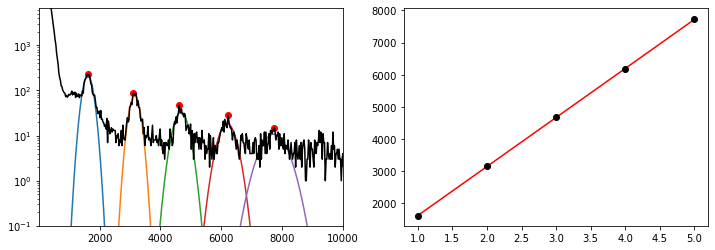

Working on file #1: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_33.40OV_source_0.h5
Distance:  35
Guess:  [281, 1488.226717557252, 50]
Params:  [ 253.72627188 1496.71999766  141.89586961]
Guess:  [91, 2888.9106870229007, 50]
Params:  [  81.50341489 2924.17056004  143.67273356]
Guess:  [49, 4364.631297709924, 50]
Params:  [  37.38598297 4338.83275833  186.27181556]
Guess:  [29, 5715.290839694657, 50]
Params:  [  21.53194304 5745.78511678  233.76676322]
Guess:  [20, 7266.048091603054, 50]
Params:  [  11.21832068 7214.33693406  325.0403245 ]
[ 253.72627188 1496.71999766  141.89586961]
[  81.50341489 2924.17056004  143.67273356]
[  37.38598297 4338.83275833  186.27181556]
[  21.53194304 5745.78511678  233.76676322]
[  11.21832068 7214.33693406  325.0403245 ]


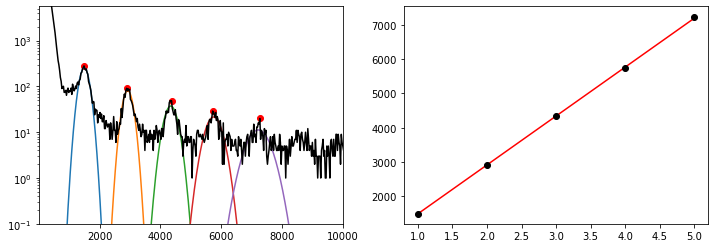

Working on file #2: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_32.90OV_source_0.h5
Distance:  30
Guess:  [288, 1338.1534351145037, 50]
Params:  [ 270.59251723 1380.75037266  139.23191591]
Guess:  [99, 2713.8251908396946, 50]
Params:  [  83.4108142  2699.97243558  144.04611593]
Guess:  [46, 4014.460305343511, 50]
Params:  [  36.4226451  4006.2105141   184.95610045]
Guess:  [27, 5315.095419847328, 50]
Params:  [  17.30556296 5309.1127001   236.73870708]
Guess:  [16, 6615.730534351145, 50]
Params:  [  12.97043944 6620.04411653  227.52219233]
[ 270.59251723 1380.75037266  139.23191591]
[  83.4108142  2699.97243558  144.04611593]
[  36.4226451  4006.2105141   184.95610045]
[  17.30556296 5309.1127001   236.73870708]
[  12.97043944 6620.04411653  227.52219233]


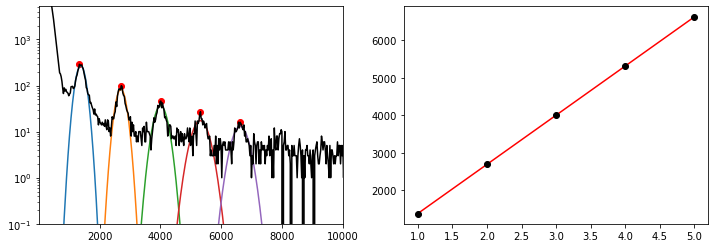

Working on file #3: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_32.40OV_source_0.h5
Distance:  25
Guess:  [308, 1263.1167938931299, 50]
Params:  [ 292.22070401 1272.339706    130.58759459]
Guess:  [109, 2488.7152671755725, 50]
Params:  [  94.40371144 2468.30095109  139.17036968]
Guess:  [44, 3689.3015267175574, 50]
Params:  [  34.45119451 3666.7437966   197.11603571]
Guess:  [29, 4889.887786259542, 50]
Params:  [  17.86195259 4879.78888115  244.58698841]
Guess:  [16, 6015.437404580152, 50]
Params:  [  11.26144883 6049.36126696  326.99630805]
[ 292.22070401 1272.339706    130.58759459]
[  94.40371144 2468.30095109  139.17036968]
[  34.45119451 3666.7437966   197.11603571]
[  17.86195259 4879.78888115  244.58698841]
[  11.26144883 6049.36126696  326.99630805]


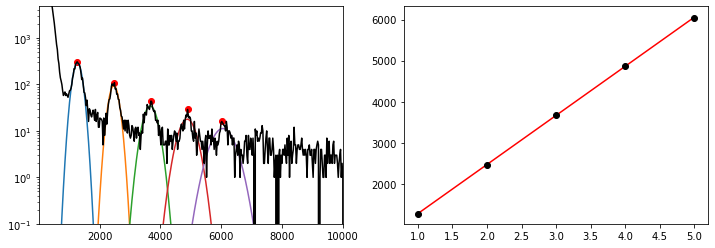

Working on file #4: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_31.90OV_source_0.h5
Distance:  25
Guess:  [318, 1138.05572519084, 50]
Params:  [ 295.50559503 1165.383642    123.32421676]
Guess:  [105, 2238.593129770992, 50]
Params:  [  90.59293521 2249.58907616  153.12309702]
Guess:  [52, 3314.118320610687, 50]
Params:  [  39.29958974 3316.79489591  185.1952523 ]
Guess:  [32, 4364.631297709924, 50]
Params:  [  19.59057165 4364.05607049  235.64785005]
Guess:  [19, 5515.1931297709925, 50]
Params:  [  13.27526758 5471.40095899  238.28577696]
[ 295.50559503 1165.383642    123.32421676]
[  90.59293521 2249.58907616  153.12309702]
[  39.29958974 3316.79489591  185.1952523 ]
[  19.59057165 4364.05607049  235.64785005]
[  13.27526758 5471.40095899  238.28577696]


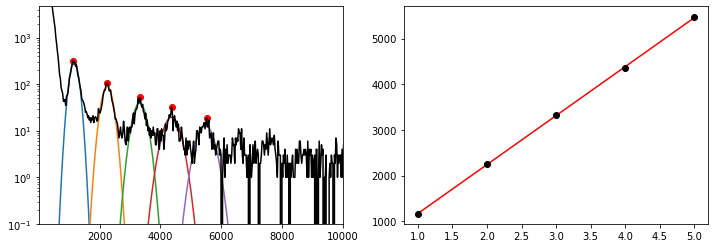

Working on file #5: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_31.40OV_source_0.h5
Distance:  25
Guess:  [325, 1038.0068702290077, 50]
Params:  [ 306.42996765 1053.92364148  121.32281604]
Guess:  [101, 2013.48320610687, 50]
Params:  [  90.43656233 2006.63338439  140.08398959]
Guess:  [46, 2988.959541984733, 50]
Params:  [  38.16630004 2973.64840556  168.83262701]
Guess:  [27, 3889.3992366412213, 50]
Params:  [  19.60068683 3927.45064629  213.4181479 ]
Guess:  [18, 4989.936641221374, 50]
Params:  [  11.3225269  4936.75252562  218.92990339]
[ 306.42996765 1053.92364148  121.32281604]
[  90.43656233 2006.63338439  140.08398959]
[  38.16630004 2973.64840556  168.83262701]
[  19.60068683 3927.45064629  213.4181479 ]
[  11.3225269  4936.75252562  218.92990339]


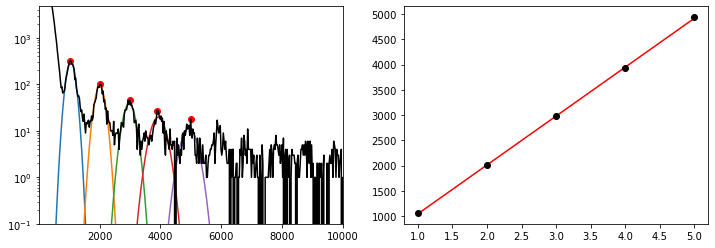

Working on file #6: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_30.90OV_source_0.h5
Distance:  20
Guess:  [328, 937.9580152671756, 50]
Params:  [301.27649979 927.40609916 122.61840544]
Guess:  [113, 1763.3610687022901, 50]
Params:  [  96.2972101  1774.25929151  135.81395902]
Guess:  [53, 2588.7641221374047, 50]
Params:  [  36.29214999 2605.78676434  166.58481221]
Guess:  [23, 3489.203816793893, 50]
Params:  [  18.74031864 3469.49887782  199.9052823 ]
Guess:  [19, 4339.6190839694655, 50]
Params:  [  11.83889097 4299.08503156  198.22315336]
[301.27649979 927.40609916 122.61840544]
[  96.2972101  1774.25929151  135.81395902]
[  36.29214999 2605.78676434  166.58481221]
[  18.74031864 3469.49887782  199.9052823 ]
[  11.83889097 4299.08503156  198.22315336]


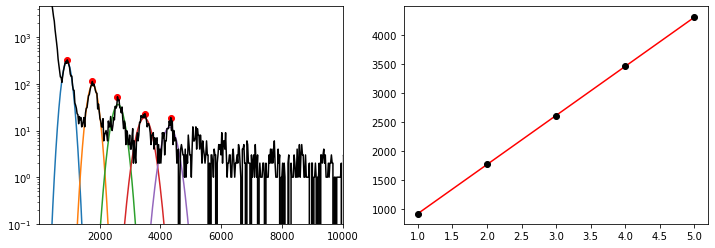

Working on file #7: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_30.40OV_source_0.h5
Distance:  15
Guess:  [336, 812.8969465648855, 50]
Params:  [356.53254324 724.06758069 176.80684425]
Guess:  [96, 1513.2389312977098, 50]
Params:  [  86.82462507 1531.72887091  138.58189851]
Guess:  [38, 2213.5809160305344, 50]
Params:  [  27.54622726 2229.84389338  204.96828771]
Guess:  [29, 2988.959541984733, 50]
Params:  [  18.05230722 2993.36735028  144.37683917]
Guess:  [15, 3689.3015267175574, 50]
Params:  [  11.37254904 3695.65112814  202.99382841]
[356.53254324 724.06758069 176.80684425]
[  86.82462507 1531.72887091  138.58189851]
[  27.54622726 2229.84389338  204.96828771]
[  18.05230722 2993.36735028  144.37683917]
[  11.37254904 3695.65112814  202.99382841]


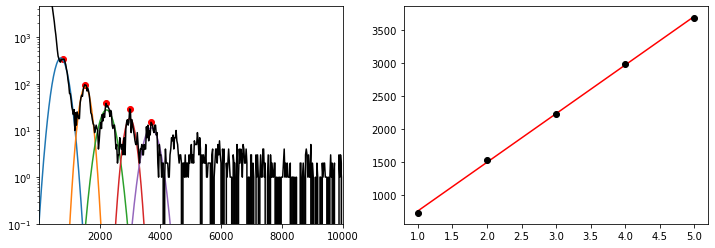

Working on file #8: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_29.90OV_source_0.h5
Distance:  15
Guess:  [92, 1288.1290076335877, 50]
Params:  [  88.02368633 1287.20091189  111.19033706]
Guess:  [38, 1888.42213740458, 50]
Params:  [  33.61054349 1903.33856607  132.58239273]
Guess:  [27, 2488.7152671755725, 50]
Params:  [  19.2584652  2470.98014536  235.70551287]
Guess:  [16, 3239.0816793893127, 50]
Params:  [  10.63393064 3073.21384289  237.28582798]
Guess:  [13, 3689.3015267175574, 50]
Params:  [   9.27467966 3709.26265801  102.2112352 ]
[  88.02368633 1287.20091189  111.19033706]
[  33.61054349 1903.33856607  132.58239273]
[  19.2584652  2470.98014536  235.70551287]
[  10.63393064 3073.21384289  237.28582798]
[   9.27467966 3709.26265801  102.2112352 ]


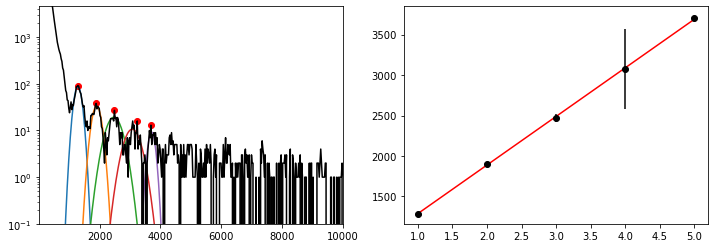

Working on file #9: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_29.40OV_source_0.h5
Distance:  15
Guess:  [84, 1088.0312977099238, 50]
Params:  [  79.79532491 1028.73640655  133.45122758]
Guess:  [34, 1563.2633587786258, 50]
Params:  [  28.82683069 1506.84273558  162.65982958]
Guess:  [20, 2013.48320610687, 50]
Params:  [  17.71158763 2010.66904986   87.34029452]
Guess:  [14, 2463.7030534351143, 50]
Params:  [   9.91990177 2512.86595635  184.75502903]
Guess:  [11, 3013.9717557251906, 50]
Params:  [   7.15465632 3054.83844515  123.20705375]
[  79.79532491 1028.73640655  133.45122758]
[  28.82683069 1506.84273558  162.65982958]
[  17.71158763 2010.66904986   87.34029452]
[   9.91990177 2512.86595635  184.75502903]
[   7.15465632 3054.83844515  123.20705375]


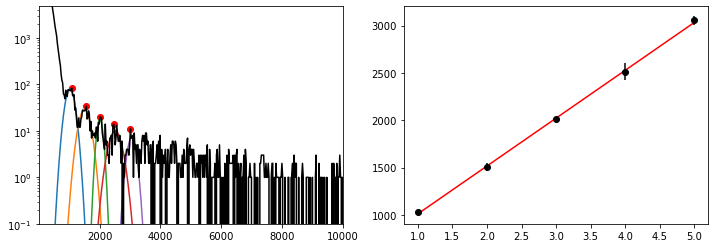

In [7]:
guess_1pe = 1100 * SRS_gain/100 - pedestal ## based on highest gain data
guess_sig = 0.1

distances = [40, 35, 30, 25, 25, 25, 20, 15, 15, 15]

gain_vs_volts = {}
for i,(file, dist) in enumerate(zip(file_list, distances)): 
    print("Working on file #%d: %s"%(i,file))
    print('Distance: ', dist)

    file_parts = file.split("_")
    file_volts = float( file_parts[-3][:-2] ) # get voltage from filename
    try:
        file_wavelength = float(file_parts[-2]) # get wavelength from filename
    except ValueError:
        file_wavelength = file_parts[-2] # leaving tag as a string for source data



    f = h5py.File(file, 'r')  
    ch2 = f.get('ch2')
    for key in ch2.keys():
        mca_hist = np.array(ch2.get(key))
    bin_num = np.arange(len(mca_hist))
    b, c = rebin_histogram(bin_num, mca_hist, 25)
    peak_info, pe_locs, peaks = find_peaks_and_fit(b, c, file_volts, min_distance=dist)
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(peaks[:,0], peaks[:,1], 'o', color='r')
    
    for fit_params in peak_info:
        print(fit_params)
        plt.plot(b, gauss_fun(b, *fit_params))
    
#     plt.scatter(b, c, marker='.')
#     plt.plot(b, c, 'k')
#     plt.ylim(0.1, 350)
    plt.semilogy(b, c, 'k')
    plt.ylim(0.1, np.max(mca_hist)*2)
    plt.xlim(0.1, 10000)
    
#     plt.xlim(0, guess_1pe*6)

### don't think that we are using this
#     if(len(gain_vs_volts) > 0):
#         guess_1pe = gain_vs_volts[-1][1] * (file_volts-breakdown)/(gain_vs_volts[-1][0]-breakdown) 

    plt.subplot(1,2,2)
    plt.errorbar( pe_locs[:,0], pe_locs[:,1], yerr=pe_locs[:,2], fmt='ko' )

    xx, gain_params, gain_cov = gain_fit(pe_locs)
    plt.plot( xx, lin_fun(xx, *gain_params), 'r')
    
    if file_wavelength not in gain_vs_volts:
        gain_vs_volts[file_wavelength] = [np.array([file_volts, gain_params[0], np.sqrt(gain_cov[0,0])])]
        
    else:
        gain_vs_volts[file_wavelength].append(np.array([file_volts, gain_params[0], np.sqrt(gain_cov[0,0])]))

    plt.show()

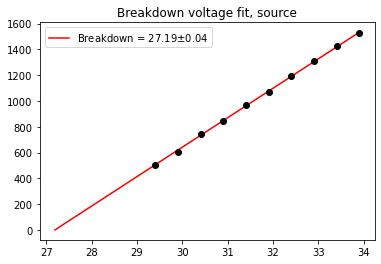

In [8]:
##### print(gain_vs_volts) ## 2nd array - last value looks WAY off
wavelengths = ['source']
# gain_vs_volts[wavelengths] = np.asarray(gain_vs_volts[wavelengths])

for wl in wavelengths:
    breakdown, break_cov = find_bv(gain_vs_volts, wl)
    
    bv_data = np.asarray(gain_vs_volts[wl])
    plt.figure()
    plt.errorbar(bv_data[:,0], bv_data[:,1], yerr=bv_data[:,2], fmt='ko')
    x_bv = np.linspace(breakdown[1], np.max(bv_data[:,0]), 100)
    plt.plot(x_bv, lin_fun(x_bv,*breakdown), 'r', label="Breakdown = %.2f$\pm$%.2f"%(breakdown[1], np.sqrt(break_cov[1,1])))
    plt.title("Breakdown voltage fit, {}".format(wl))
    plt.legend()
    plt.show()
    
# wl_to_use = gain_vs_volts[:,3] == 405 ###### was this only to select 405 nm data?
# print(wl_to_use)
# print(np.array(gain_vs_volts[wl_to_use,:]))

In [9]:
## Plot latest file

path = r"C:/Data/20230213/Step16/"

type_list = ['source']#, '405', '310']
col_list = ['k', 'b', 'purple']
nfiles = 1
norm_range = [3000, 12000] ## set range to normalize counts (leave empty to not use)

ref_hist = 0
fig1 = plt.figure(figsize=(20,4))
fig2 = plt.figure(figsize=(6,4))
for j,t in enumerate(type_list):
    file_list = natsort.realsorted(glob.glob(path + "*mca*%s*.h5"%t))
    print("Found %d files"%len(file_list))


    for i,file in enumerate(file_list[-nfiles:]): 
        print("Working on file #%d: %s"%(i,file))

        #file_parts = file.split("_")
        #file_volts = float( file_parts[-2][:-2] ) # get voltage from filename

        f = h5py.File(file, 'r')  
        ch2 = f.get('ch2')
        for key in ch2.keys():
            mca_hist = np.array(ch2.get(key))
        bin_num = np.arange(len(mca_hist))

        b, c = rebin_histogram(bin_num, mca_hist, 1)

        if(len(norm_range)==2):
            gpts = (b < norm_range[1]) & (b > norm_range[0])
            norm_fac = np.sum(c[gpts])
        else:
            norm_fac = 1

        if(t == "source"):
            ref_hist = c/norm_fac
        plt.figure(fig1.number)
        plt.semilogy(b, c/norm_fac, color=col_list[j])
        plt.ylim(1e-3,1e-1)
        plt.xlim(0,1000)

        plt.figure(fig2.number)
        plt.plot(b, c/norm_fac - ref_hist, color=col_list[j])
        plt.ylim(0,1)
        plt.xlim(0,4000)

plt.show()

Found 0 files


<Figure size 1440x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>